In [1]:
import math
import requests
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from requests.exceptions import ConnectionError

# Modelo 3

En este modelo los principales cambios fueron:

* Aplicamos **"Class Weighting"** para contrarrestar los datos desbalanceados.


* Se procesaron los datos enteros con ``dataProcessing(df)`` en el dataframe entero y luego separamos los datos en train set y test set. Anteriormente se había hecho esto pero en orden inverso. Esto ayudó a corregir unos errores que salían en las predicciones.

In [2]:
try:
    from pyspark.sql import SparkSession
except:
    import findspark
    findspark.init()
    from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("COVID") \
        .config("hive.exec.dynamic.partition", "true")\
        .config("hive.exec.dynamic.partition.mode", "nonstrict") \
        .enableHiveSupport()\
        .getOrCreate()

sc=spark.sparkContext

In [4]:
def filtraPositivos(df):
    """
    Esta función filtra los casos positivos de un DataFrame dado.
    df: spark DataFrame con la columna 'resultado'
    """
    #Devolvemos nuestro df con los casos positivos
    return df.filter(df.RESULTADO == 'Positivo SARS-CoV-2')

In [5]:
def limpiaNulls(df):
    """
    Función que limpia nulls en un DF de spark e imprime
    la cantidad de registros que borró (cantidad de valores
    nulos).
    """
    cleanDF = df.na.drop()
    
    print("Numero de registros con algun valor nulo: ", df.count() - cleanDF.count())
    return cleanDF

#### Cargamos nuestros datos

In [6]:
#path del archivo csv
file_local_path = 'C:/Users/nieto/Desktop/casos-asociados-a-covid-19.csv'

#cargamos el archivo en un spark DataFrame
df_origen = spark.read.csv(file_local_path, header=True, encoding='UTF-8', inferSchema=True)

#covariables que vamos a tomar en cuenta para el modelo
features = ["TIPO PACIENTE", "SEXO", "EDAD", "EMBARAZO", "DIABETES", "EPOC", "ASMA", "INMUNOSUPRESION", "HIPERTENSION",
            "OTRA COMPLICACION", "CARDIOVASCULAR", "OBESIDAD", "RENAL CRONICA", "TABAQUISMO","RESULTADO"]
df = df_origen.select(features)

#filtramos los casos positivos
df = filtraPositivos(df)
#ya no necesitamos la columna resultado
df = df.drop('RESULTADO')
#limpiamos nuestra información
df = limpiaNulls(df)
#creamos una vista temporal en spark
df.createOrReplaceTempView('covid')

Numero de registros con algun valor nulo:  0


In [7]:
#cargamos lo que necesitamos de spark.ml
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, MinMaxScaler, ChiSqSelector

#### Procesamiento de datos de entrenamiento

In [8]:
def dataProcessing(train, categoricalCols, numericalCols, labelCol="TIPO PACIENTE"):
    """Función que hace todo el preprocesamiento de los datos
    categóricos de un conjunto de datos de entrenamiento (o no).
    :param train spark df: conjunto de datos de entrenamiento.
    :param categoricalCols list,array: conjunto de nombres de columnas categoricas del
        conjunto de datos train.
    :param numericalCols list,array: conjunto de nombres de columnas numéricas del 
        conjunto de datos train.
    :param labelCol str: variable objetivo o etiqueta
    
    :Returns spark dataframe con las columnas 'label' y 'features'
    """
    
    #codificamos todas las variables categóricas
    stages = []
    for categoricalCol in categoricalCols:
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol= categoricalCol + "Index")
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                        outputCols=[categoricalCol + "ohe"])
        stages += [stringIndexer, encoder]

    #variable objetivo (etiqueta)
    label_strIdx = StringIndexer(inputCol=labelCol, outputCol="label")
    stages += [label_strIdx]

    #ponemos todas las covariables en un vector
    assemblerInputs = [c + "ohe" for c in categoricalCols] + numericalCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="feat")
    stages += [assembler]
    
    #seleccionamos las variables que nos sirven con ChiSqSelector
    selector = ChiSqSelector(featuresCol="feat", outputCol="feature", labelCol="label", fpr=0.05,
                            selectorType='fpr')
    stages += [selector]
    
    #escala de 0-1
    scala = MinMaxScaler(inputCol="feature", outputCol="features")
    stages += [scala]
    
    #pipeline donde vamos a hacer todo el proceso
    pipe = Pipeline(stages=stages)
    pipeModel = pipe.fit(train)
    train = pipeModel.transform(train)
    
    #regresamos nuestro df con lo que necesitamos
    return train

In [9]:
#parámetros necesarios para procesamiento de datos
categoricalCols = list(df.columns[1:])
categoricalCols.remove("EDAD")
numericalCols = ["EDAD"]

#con dataProcessing() procesamos toda nuestra data
raw_data = dataProcessing(df, categoricalCols, numericalCols, labelCol="TIPO PACIENTE")

In [10]:
#separamos nuestros datos en conjunto de entrenamiento y prueba
train, test = raw_data.randomSplit([0.70,0.30])

In [11]:
train.select("label","features").show(5,truncate=False)

+-----+-------------------------------------------------------------------------------------------------+
|label|features                                                                                         |
+-----+-------------------------------------------------------------------------------------------------+
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0]|
|0.0  |[1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
+-----+-------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [12]:
numHosp = train.filter(train["TIPO PACIENTE"]=="HOSPITALIZADO").count()
numAmb = train.filter(train["TIPO PACIENTE"]=="AMBULATORIO").count()

#BalancingRatio nos ayuda a darle más peso a la clase minoritaria
BalancingRatio = numAmb / (numHosp + numAmb)
print("Balancing Ratio: ", BalancingRatio)

Balancing Ratio:  0.6580782589818734


In [13]:
from pyspark.sql.functions import when

train=train.withColumn("classWeights", when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+-------------------+
|       classWeights|
+-------------------+
|0.34192174101812656|
|0.34192174101812656|
|0.34192174101812656|
|0.34192174101812656|
|0.34192174101812656|
+-------------------+
only showing top 5 rows



#### Entrenamiento del modelo

In [14]:
def modeloLogistico(data, labelCol="label", featuresCol="features", weightCol=""):
    """
    Función que se encarga de ajustar un modelo logístico
    a partir de un dataframe de spark con el esquema ya procesado
    a partir de la función dataProcessing().
    
    :param data: spark dataframe.
    :param labelCol: string nombre de la columna con la variable respuesta.
    :param featuresCol: string nombre de la columna con los vectores de las
        covariables.
    
    :returns modelo ajustado:
    """
    from pyspark.ml.classification import LogisticRegression
    
    model = LogisticRegression(featuresCol=featuresCol, labelCol=labelCol, weightCol=weightCol)
    return model.fit(data)

In [15]:
#Entrenamos nuestro modelo con el conjunto de entrenamiento y la función modeloLogistico()
model = modeloLogistico(data=train, labelCol="label", featuresCol="features", weightCol="classWeights")

In [16]:
print("Coeficientes: ",str(model.coefficientMatrix))
print("Intercepto: ", str(model.interceptVector))

Coeficientes:  DenseMatrix([[-0.13403303, -0.13403303, -0.80552367, -0.68498477,  0.02037849,
               0.65877411,  0.96415342,  0.29355622,  0.07751895,  0.05023836,
               0.70780579, -0.11774051,  0.10460454, -1.03072905, -0.59656785,
              -0.02266539,  0.028484  , -1.49054956, -1.21017843,  1.05460994,
               1.9444462 ,  0.43420388,  0.31785505,  5.79677078]])
Intercepto:  [-1.272242575143932]


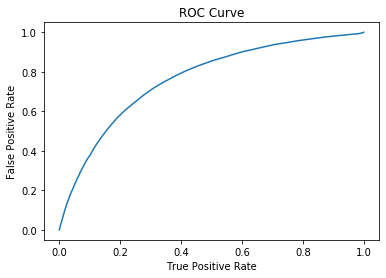

Training set areaUnderROC: 0.7633663135741994


In [17]:
modelSummary = model.summary

roc = modelSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(modelSummary.areaUnderROC))

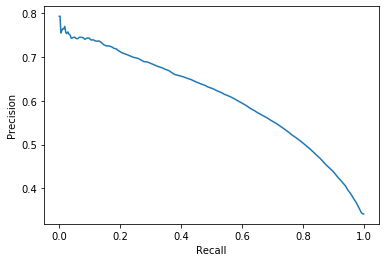

In [18]:
#Presición vs Exhaustividad (recall)
pr = modelSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Predicciones

In [19]:
def predictLogistico(test,categoricalCols, numericalCols, labelCol, model):
#     dataProcessing(train, categoricalCols, numericalCols, labelCol="TIPO PACIENTE")
    """
    Esta función predice un modelo logístico con columnas categóricas
    y numéricas sobre un conjunto de datos de prueba.
    """
    predictions = model.transform(test)
    #regresamos el df con las predicciones
    return predictions

In [20]:
#hacemos nuestras predicciones aplicándole el modelo a nuestro conjunto de prueba
pred = model.transform(test)

In [21]:
#Matriz de confusión
#índice: etiqueta real
#columnas: predicción de nuestro modelo
pred.groupby("label").pivot("prediction").count().show()

+-----+-----+----+
|label|  0.0| 1.0|
+-----+-----+----+
|  0.0|15119|5878|
|  1.0| 3406|7573|
+-----+-----+----+



In [23]:
#AUROC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Training set Area Under ROC: ' + str(modelSummary.areaUnderROC))
print('Test set Area Under ROC', evaluator.evaluate(pred))

Training set Area Under ROC: 0.7633663135741994
Test set Area Under ROC 0.7645725377264613


## Conclusión:

El modelo se mejora levemente con el método "Class Weighting" así que vamos a dejar esta implementación.